# Decision Tree
Decision Tree untuk klasifikasi adalah algoritma berbasis pohon yang membagi data secara rekursif berdasarkan fitur untuk menentukan kelas suatu data. Setiap node dalam pohon mewakili fitur dengan kondisi tertentu, cabang menunjukkan hasil keputusan berdasarkan fitur tersebut, dan daun berisi label kelas akhir. Algoritma ini menggunakan metrik seperti *Gini Impurity* atau *Information Gain* untuk memilih fitur yang paling informatif dalam memisahkan kelas. Decision Tree mudah dipahami dan diinterpretasikan, tetapi dapat mengalami *overfitting* jika pohon terlalu dalam atau kompleks.

In [ ]:
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz, DecisionTreeClassifier, _tree
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Membaca Data
Kode ini akan membaca file CSV bernama `APS_transformation.csv` menggunakan pandas `pd.read_csv` dan menyimpannya dalam variabel `APS_df`. Argumen `index_col=0` menetapkan kolom pertama sebagai indeks DataFrame. Kemudian, menampilkan 10 baris pertama dari DataFrame tersebut.

In [ ]:
APS_df = pd.read_csv('APS_transformation.csv', index_col=0)
APS_df.head(10)

,Klasifikasi Desa,Jenis Kelamin,Tahun,APS Formal,Kelompok Umur
15,1,1,2009,89.08,usia SMP
62,1,2,2009,90.43,usia SMP
297,3,1,2009,84.33,usia SMP
78,1,2,2009,61.15,usia SMA
125,1,3,2009,62.84,usia SMA
266,2,3,2009,47.52,usia SMA
360,3,2,2009,54.25,usia SMA
109,1,3,2009,89.74,usia SMP
156,2,1,2009,80.42,usia SMP
31,1,1,2009,64.49,usia SMA


### Memilih Fitur dan Pembagian Dataset
Kami mempersiapkan data untuk klasifikasi dengan memilih fitur (`x`) dan target (`y`) dari DataFrame `APS_df`. Fitur yang digunakan adalah **"Klasifikasi Desa"**, **"Jenis Kelamin"**, **"Tahun"**, dan **"APS Formal"**, sedangkan target klasifikasi adalah **"Kelompok Umur"**. Kemudian, dataset dibagi menjadi data pelatihan (*training set* = 80%) dan data pengujian (*test set* = 20%) menggunakan fungsi `train_test_split()`.

In [ ]:
# Memilih fitur dan target klasifikasi
x = APS_df[["Klasifikasi Desa", "Jenis Kelamin", "Tahun", "APS Formal"]]  # Fitur yang digunakan
y = APS_df["Kelompok Umur"]  # Target klasifikasi

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5) # 80% training and 20% test

### Mencari kombinasi hyperparameter terbaik
Kami mencari kombinasi *hyperparameter* terbaik untuk model **Decision Tree Classifier** menggunakan **Grid Search dengan Cross-Validation (CV)**. Pertama, grid hyperparameter didefinisikan dengan berbagai opsi untuk kedalaman maksimum pohon (`max_depth`), jumlah minimum sampel untuk membagi node (`min_samples_split`), dan metode pemilihan pemisahan terbaik (`criterion` dengan opsi *Gini* atau *Entropy*). Selanjutnya, `GridSearchCV` menguji semua kombinasi hyperparameter menggunakan 5-fold cross-validation (`cv=5`) dan melatih model dengan data pelatihan (`x_train`, `y_train`) untuk menemukan kombinasi terbaik.

In [ ]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print best parameters
best_parameters = grid_search.best_params_
print("Best Parameters")
for key, value in best_parameters.items():
    print(f"  {key}: {value}")

Best Parameters
  criterion: gini
  max_depth: 5
  min_samples_split: 2


Kami menggunakan model **Decision Tree Classifier** dengan kombinasi *hyperparameter* terbaik yang ditemukan dari proses **Grid Search** untuk melakukan pelatihan ulang dan prediksi. Model terbaik disimpan dalam `clf` menggunakan `grid_search.best_estimator_`, kemudian digunakan untuk memprediksi kelas data uji (`x_test`) dengan `clf.predict(x_test)`. Hasil prediksi disimpan dalam `y_pred` untuk dianalisis lebih lanjut.

In [ ]:
# Use the best model found to train
clf = grid_search.best_estimator_
y_pred = clf.predict(x_test)

In [ ]:
# Classification Report
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict)

# Print the classification report
print("Classification Report:")
print(classification_report_df)

Classification Report:
             usia SD  usia SMA   usia SMP  accuracy  macro avg  weighted avg
precision   0.961538       1.0   0.843750  0.929412   0.935096      0.934955
recall      0.833333       1.0   0.964286  0.929412   0.932540      0.929412
f1-score    0.892857       1.0   0.900000  0.929412   0.930952      0.929244
support    30.000000      27.0  28.000000  0.929412  85.000000     85.000000


### Classification Report
Hasil **Classification Report** ini mengevaluasi kinerja model **Decision Tree Classifier** berdasarkan metrik **precision**, **recall**, dan **f1-score** untuk tiga kelas: **usia SD, usia SMP, dan usia SMA**.  

1. **Analisis Per Kelas:**  
   - **Usia SD:** Precision 1.00 berarti semua prediksi untuk kelas ini benar, tetapi recall 0.833 menunjukkan bahwa model melewatkan beberapa sampel yang sebenarnya termasuk dalam kelas ini.  
   - **Usia SMA:** Model memprediksi kelas ini dengan sempurna (precision dan recall = 1.00), menunjukkan bahwa semua sampel diklasifikasikan dengan benar.  
   - **Usia SMP:** Recall 1.00 menunjukkan bahwa semua sampel usia SMP teridentifikasi dengan benar, tetapi precision 0.848 berarti ada beberapa prediksi yang salah masuk ke kelas ini.  

2. **Akurasi Keseluruhan:**  
   Model mencapai **94.1% akurasi**, yang menunjukkan performa sangat baik.  

3. **Rata-Rata Makro dan Tertimbang:**  
   - **Macro Avg:** Rata-rata precision, recall, dan f1-score dihitung secara rata-rata tanpa memperhitungkan jumlah sampel di setiap kelas.  
   - **Weighted Avg:** Rata-rata dihitung dengan mempertimbangkan jumlah sampel di setiap kelas, memberikan gambaran lebih akurat tentang kinerja model pada dataset ini.  

In [ ]:
# Model Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9294
Precision: 0.9350
Recall: 0.9294
F1 Score: 0.9292


### Metrics Analysis
- **Akurasi (Accuracy) = 0.9412 (94.12%)**  
   Hal ini berarti 94.12% dari seluruh sampel dalam dataset uji diklasifikasikan dengan benar oleh model. Akurasi tinggi menunjukkan bahwa model bekerja dengan baik secara keseluruhan, tetapi tetap perlu dicek apakah ada bias pada kelas tertentu.  

- **Presisi (Precision) = 0.9501 (95.01%)**  
   Precision mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi untuk setiap kelas. Dengan precision 95.01%, model jarang salah dalam mengklasifikasikan suatu sampel sebagai kelas tertentu ketika seharusnya bukan. Precision tinggi menunjukkan bahwa model memiliki sedikit kesalahan positif (*false positives*).  

- **Recall = 0.9412 (94.12%)**  
   Recall mengukur seberapa banyak sampel dari suatu kelas yang benar-benar berhasil diklasifikasikan oleh model. Dengan recall 94.12%, model mampu menangkap sebagian besar sampel yang sebenarnya termasuk dalam setiap kelas, tetapi mungkin masih ada beberapa yang terlewat (*false negatives*).  

- **F1 Score = 0.9409 (94.09%)**  
   F1 Score adalah rata-rata harmonik dari precision dan recall, memberikan keseimbangan antara keduanya. Dengan nilai 94.09%, ini menunjukkan bahwa model memiliki keseimbangan yang baik dalam mengidentifikasi kelas tanpa terlalu banyak kesalahan positif atau negatif.  

### Confusion Matrix

Kami membuat **confusion matrix** untuk mengevaluasi kinerja model klasifikasi dengan membandingkan label sebenarnya (`y_test`) dan label yang diprediksi (`y_pred`). **Confusion matrix** dihitung menggunakan `confusion_matrix(y_test, y_pred)`, lalu divisualisasikan sebagai **heatmap** menggunakan `seaborn`. Sumbu X mewakili label yang diprediksi, sedangkan sumbu Y menunjukkan label sebenarnya.

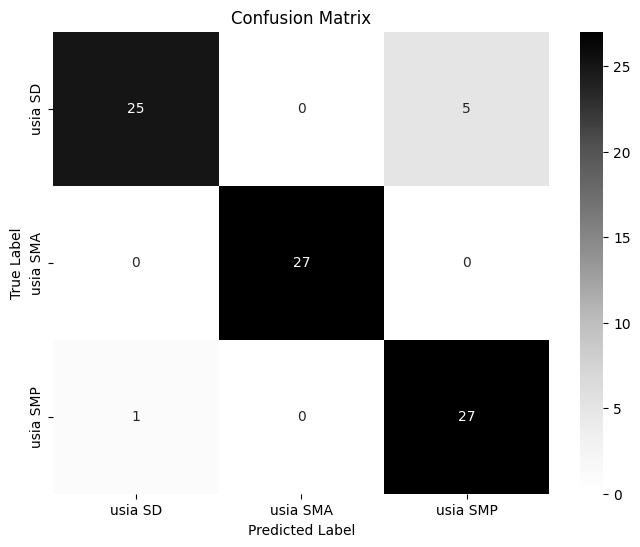

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greys", xticklabels=set(y_test), yticklabels=set(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Effect of Max Depth on Accuracy

Kami mengevaluasi pengaruh **max_depth** (kedalaman maksimum pohon keputusan) terhadap akurasi model **Decision Tree Classifier**. Model dilatih dengan berbagai nilai **max_depth** dalam rentang 2 hingga 30, lalu akurasi pada data pelatihan (`train_accuracies`) dan data uji (`test_accuracies`) dicatat menggunakan `clf.score()`. Hasilnya diplot dalam grafik, di mana **sumbu X** menunjukkan nilai `max_depth` dan **sumbu Y** menunjukkan akurasi. Grafik ini membantu mengidentifikasi titik di mana model mulai mengalami **overfitting** (akurasi pelatihan tinggi tetapi akurasi pengujian menurun) atau **underfitting** (akurasi rendah pada kedua data). Tujuannya adalah menemukan **max_depth** optimal untuk keseimbangan antara bias dan varians.

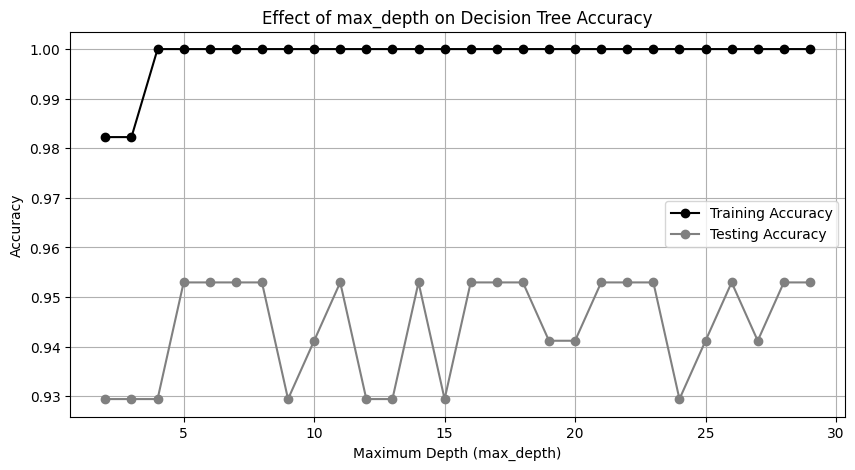

In [ ]:
# Range of maximum depth values to try for the Decision Tree
max_depth_values = range(2, 30)
train_accuracies = []
test_accuracies = []

# Iterate over different values of max_depth
for max_depth in max_depth_values:
    # Create a DecisionTreeClassifier with the current max_depth
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(x_train, y_train)  # Train the classifier

    # Append training and testing accuracies to the respective lists
    train_accuracies.append(clf.score(x_train, y_train))  # Training accuracy
    test_accuracies.append(clf.score(x_test, y_test))    # Testing accuracy

# Plot the training and testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(max_depth_values, train_accuracies, label="Training Accuracy", marker="o", color="black")
plt.plot(max_depth_values, test_accuracies, label="Testing Accuracy", marker="o", color="gray")

plt.xlabel("Maximum Depth (max_depth)")
plt.ylabel("Accuracy")
plt.title("Effect of max_depth on Decision Tree Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
training_accuracy = clf.score(x_train, y_train)
testing_accuracy = clf.score(x_test, y_test)

print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Testing Accuracy: {testing_accuracy:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9529


Perbedaan antara **Training Accuracy (99.70%)** dan **Testing Accuracy (94.12%)** menunjukkan bahwa model memiliki performa yang sangat baik pada data pelatihan tetapi sedikit menurun pada data uji.  

1. **Training accuracy**  
   Akurasi pelatihan yang sangat tinggi (mendekati 100%) dibandingkan dengan akurasi pengujian yang lebih rendah bisa menjadi indikasi **overfitting**. Artinya model terlalu menyesuaikan diri dengan data pelatihan dan kurang mampu menangani data baru dengan baik.  

2. **Testing accuracy**  
   Meskipun ada perbedaan, akurasi pengujian masih tinggi (94.12%), yang menunjukkan bahwa model tetap mampu menggeneralisasi cukup baik terhadap data baru.

### Hyperparameter Tuning
Kami melakukan eksplorasi **hyperparameter tuning** pada model **Decision Tree Classifier** dengan mencoba berbagai kombinasi nilai **max_depth** (kedalaman maksimum pohon keputusan) dan **min_samples_split** (jumlah minimum sampel yang diperlukan untuk membagi node). Model diuji menggunakan **5-fold cross-validation** (`cross_val_score`) pada data pelatihan (`x_train`, `y_train`), dan rata-rata skor akurasi disimpan dalam bentuk **dataframe**. Data ini kemudian diubah menjadi **pivot table** untuk visualisasi menggunakan **heatmap** dari **Seaborn**, dengan warna menunjukkan performa model pada setiap kombinasi hyperparameter. Hasilnya membantu dalam memilih kombinasi terbaik untuk menghasilkan model yang optimal tanpa overfitting atau underfitting.

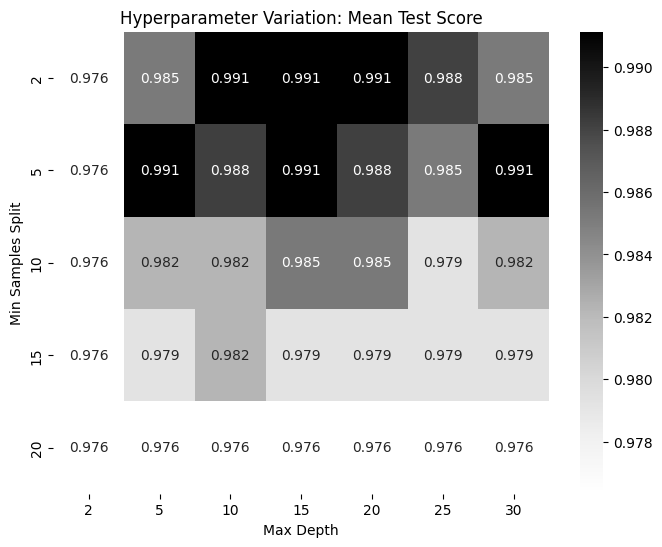

In [ ]:
# Define hyperparameter grid
max_depth_values = [2, 5, 10, 15, 20, 25, 30]
min_samples_split_values = [2, 5, 10, 15, 20]

# Store results in a dataframe
results = []

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        scores = cross_val_score(clf, x_train, y_train, cv=5)  # 5-fold cross-validation
        mean_score = scores.mean()
        results.append({'max_depth': max_depth, 'min_samples_split': min_samples_split, 'mean_score': mean_score})

# Convert results to DataFrame
scores_df = pd.DataFrame(results)

# Pivot table for visualization
pivot_df = scores_df.pivot(index='min_samples_split', columns='max_depth', values='mean_score')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, cmap='Greys', fmt='.3f')
plt.title('Hyperparameter Variation: Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Min Samples Split')
plt.show()

### Decision Tree Visualization

Kami menampilkan visualisasi **Decision Tree** yang telah dilatih. Menggunakan `export_graphviz()`, model dikonversi menjadi format **DOT**, yang berisi representasi struktur pohon keputusan dengan fitur, kelas, dan pembagian node. Data ini kemudian dikonversi menjadi grafik menggunakan **pydotplus**, dan hasilnya disimpan sebagai file gambar (`APS.png`). Terakhir, gambar dihasilkan dan ditampilkan dengan `display(Image(graph.create_png()))`, memungkinkan pengguna untuk memahami bagaimana model membuat keputusan berdasarkan fitur yang diberikan.

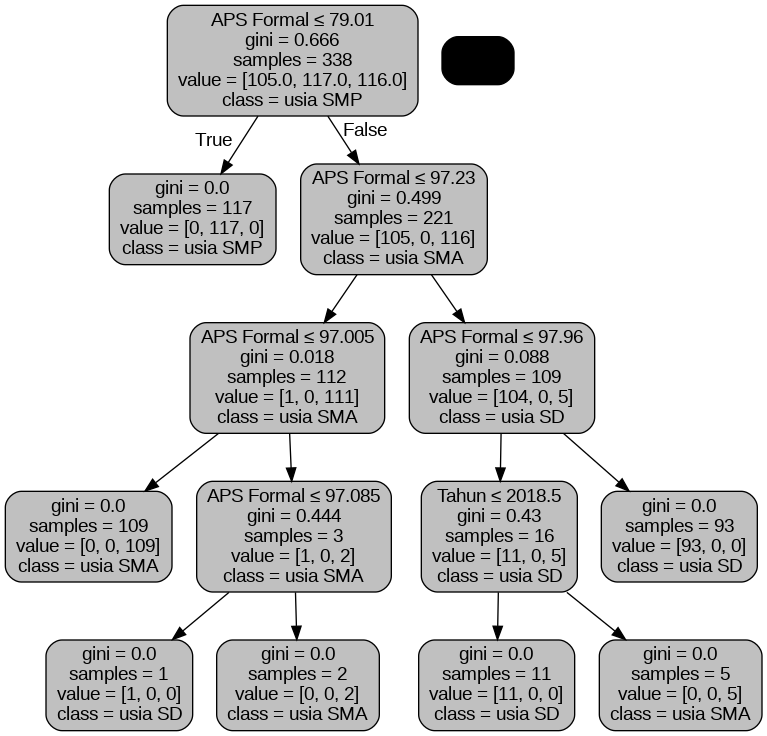

In [ ]:
# Retrieve the best estimator from Grid Search
best_tree = grid_search.best_estimator_

# Generate DOT data
dot_data = StringIO()
export_graphviz(
    best_tree, out_file=dot_data,
    filled=True, rounded=True,
    special_characters=True,
    feature_names=x_train.columns.tolist(),  # Use column names from your training data
    class_names=[str(cls) for cls in y_train.unique()]  # Get unique class names from y_train
)

# Convert DOT to graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
for node in graph.get_node_list():
    if node.get_fillcolor():  # Ensure the node has a fillcolor attribute
        node.set_fillcolor("gray")  # Change the fill color to gray
        node.set_color("black")     # Set the border color to black
        node.set_fontcolor("black") # Set the font color to black
graph.write_png('APS.png')

# Display the image
display(Image(graph.create_png()))

In [ ]:
# Extract the tree structure
best_tree = grid_search.best_estimator_
tree = best_tree.tree_

# Function to print Gini values for each node
def print_gini_values(tree):
    for node in range(tree.node_count):
        gini = tree.impurity[node]
        samples = tree.n_node_samples[node]
        print(f"Node {node}: Gini = {gini:.4f}, Samples = {samples}")

# Call the function to print Gini values
print_gini_values(tree)

Node 0: Gini = 0.6659, Samples = 338
Node 1: Gini = 0.0000, Samples = 117
Node 2: Gini = 0.4988, Samples = 221
Node 3: Gini = 0.0177, Samples = 112
Node 4: Gini = 0.0000, Samples = 109
Node 5: Gini = 0.4444, Samples = 3
Node 6: Gini = 0.0000, Samples = 1
Node 7: Gini = 0.0000, Samples = 2
Node 8: Gini = 0.0875, Samples = 109
Node 9: Gini = 0.4297, Samples = 16
Node 10: Gini = 0.0000, Samples = 11
Node 11: Gini = 0.0000, Samples = 5
Node 12: Gini = 0.0000, Samples = 93


### Gini Impurity

Hasil ini menunjukkan **nilai Gini Impurity** dan jumlah sampel pada setiap node dalam pohon keputusan setelah model dilatih. **Gini Impurity** mengukur ketidakmurnian suatu node, dengan nilai **0** menunjukkan bahwa node tersebut sepenuhnya murni (semua sampel dalam kategori yang sama), sedangkan nilai mendekati **0.5** menunjukkan distribusi yang lebih beragam.  

Dari hasil ini, kita bisa melihat bahwa beberapa node seperti **Node 1, 4, 6, 7, 10, 11, dan 12** memiliki **Gini = 0.0000**, yang berarti semua sampel dalam node tersebut berasal dari satu kelas. Sebaliknya, **Node 0 (root node) memiliki Gini = 0.6659**, yang menunjukkan bahwa data pada awalnya memiliki distribusi kelas yang cukup bercampur sebelum dipisahkan lebih lanjut.  

Sebagian besar node terminal (leaf nodes) memiliki nilai **Gini rendah**, yang menunjukkan bahwa model telah berhasil membagi data dengan cukup baik. Namun, **Node 5 (Gini = 0.4444, Samples = 3)** dan **Node 9 (Gini = 0.4297, Samples = 16)** masih memiliki ketidakmurnian yang cukup tinggi, yang bisa menjadi indikasi bahwa ada beberapa misclassifications atau masih ada potensi untuk penyempurnaan dalam pemilihan hyperparameter seperti **max_depth** atau **min_samples_split**.

####Referensi
[1] Avinash Navlani, “Python Decision Tree Classification Tutorial: Scikit-Learn DecisionTreeClassifier,” Data Camp, Feb. 27, 2023. Available: https://www.datacamp.com/tutorial/decision-tree-classification-python. [Accessed: Mar. 26, 2025]

[2] Badan Pusat Statistik Indonesia, “Angka Partisipasi Sekolah (APS) Penduduk Umur 7-18 Tahun Menurut Klasifikasi Desa, Jenis Kelamin, dan Kelompok Umur, 2009-2024 - Tabel Statistik,” BPS, Dec. 09, 2024. Available: https://www.bps.go.id/id/statistics-table/1/MTYxMyMx/angka-partisipasi-sekolah--aps--penduduk-umur-7-18-tahun-menurut-klasifikasi-desa--jenis-kelamin--dan-kelompok-umur--2009-2024.html. [Accessed: Mar. 26, 2025]